In [1]:
from openparticle.hamiltonians.yukawa_hamiltonians import yukawa_Hamiltonian
from openparticle.qubit_mappings import op_qubit_map
from openparticle import ParticleOperator
import numpy as np
import cirq
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.rescale import bosonically_rescale_terms, get_numbers_of_bosonic_operators_in_terms, get_number_of_active_bosonic_modes
from src.lobe.system import System
from src.lobe.lobe_circuit import lobe_circuit
from src.lobe.block_encoding import add_lobe_oracle
from colors import *

In [2]:
def generate_yukawa_circuit(res, max_bose_occ):

    operator = yukawa_Hamiltonian(res, 1, 1, 1)
    terms = operator.to_list()

    bosonically_rescaled_terms, bosonic_rescaling_factor = bosonically_rescale_terms(terms, max_bose_occ)
    coefficients = [term.coeff for term in bosonically_rescaled_terms]

    norm = sum(np.abs(coefficients))
    target_state = get_target_state(coefficients)
    asp_rescaling_factor = (bosonic_rescaling_factor * norm)

    number_of_modes = max([term.max_mode() for term in terms]) + 1

    number_of_ancillae = (
        1000  # Some arbitrary large number with most ancilla disregarded
    )
    number_of_index_qubits = max(int(np.ceil(np.log2(len(terms)))), 1)
    number_of_rotation_qubits = max(get_number_of_active_bosonic_modes(terms)) + 1
    


    # Declare Qubits
    validation = cirq.LineQubit(0)
    clean_ancillae = [cirq.LineQubit(i + 1) for i in range(number_of_ancillae)]
    rotation_qubits = [
        cirq.LineQubit(i + 1 + number_of_ancillae)
        for i in range(number_of_rotation_qubits)
    ]
    index_register = [
        cirq.LineQubit(i + 1 + number_of_ancillae + number_of_rotation_qubits)
        for i in range(number_of_index_qubits)
    ]
    system = System(
        number_of_modes=number_of_modes,
        maximum_occupation_number=max_bose_occ,
        number_of_used_qubits=1
        + number_of_ancillae
        + number_of_rotation_qubits
        + number_of_index_qubits,
        has_fermions=operator.has_fermions,
        has_antifermions=operator.has_antifermions,
        has_bosons=operator.has_bosons,
    )

    #### ASP Circuit Generation
    ASP_numerics = {
        "left_elbows": 0,
        "right_elbows": 0,
        "rotations": 0,
        "ancillae_tracker": [1 + number_of_rotation_qubits - 1 + number_of_index_qubits],
        "angles": [],
        "number_of_nonclifford_rotations": 0,
        "rescaling_factor": asp_rescaling_factor,
        "number_of_modes": number_of_modes,
        "maximum_bosonic_occupation": max_bose_occ,
        "maximum_number_of_active_bosonic_modes": number_of_rotation_qubits - 1,
        "number_of_terms": len(terms)
    }
    circuit = cirq.Circuit()
    circuit.append(cirq.I.on_each(*system.fermionic_register))
    circuit.append(cirq.I.on_each(*system.antifermionic_register))
    for bosonic_reg in system.bosonic_system:
        circuit.append(cirq.I.on_each(*bosonic_reg))
    circuit.append(cirq.X.on(validation))
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    circuit += add_lobe_oracle(
        bosonically_rescaled_terms,
        validation,
        index_register,
        system,
        rotation_qubits,
        clean_ancillae,
        perform_coefficient_oracle=False,
        numerics=ASP_numerics,
    )
    circuit += add_prepare_circuit(
        index_register,
        target_state=target_state,
        dagger=True,
        numerics=ASP_numerics,
        clean_ancillae=clean_ancillae
    )
    ASP_numerics["number_of_ancillae"] = max(ASP_numerics["ancillae_tracker"])
    ASP_numerics["number_of_qubits"] = max(ASP_numerics["ancillae_tracker"]) + system.number_of_system_qubits
    for angle in ASP_numerics["angles"]:
        angle = np.abs(angle)
        if not np.isclose(angle%np.pi/4, 0):
            ASP_numerics["number_of_nonclifford_rotations"] += 1
    
    return {
        "ASP": ASP_numerics 
    }

In [3]:
from symmer import PauliwordOp

In [4]:
from time import time
fix_Omega = 3
res_max = 8
number_of_res_range = range(2, res_max)

DATA_FOR_FIXED_OMEGA = []
LCU_rots_DATA_FOR_FIXED_OMEGA = []
LCU_elbows_DATA_FOR_FIXED_OMEGA = []
for res in number_of_res_range:
    start = time()
    print("----{} of {}----".format(res, max(number_of_res_range)))
    DATA_FOR_FIXED_OMEGA.append(generate_yukawa_circuit(res, fix_Omega))
    LCU_rots_DATA_FOR_FIXED_OMEGA.append(2 * op_qubit_map(yukawa_Hamiltonian(res, 1, 1, 1), fix_Omega).n_terms)
    LCU_elbows_DATA_FOR_FIXED_OMEGA.append(op_qubit_map(yukawa_Hamiltonian(res, 1, 1, 1), fix_Omega).n_terms)
    print("* {} (s) *".format(round(time() - start, 1)))



----2 of 7----
* 0.2 (s) *
----3 of 7----
* 0.8 (s) *
----4 of 7----
* 3.0 (s) *
----5 of 7----
* 9.2 (s) *
----6 of 7----
* 24.5 (s) *
----7 of 7----
* 60.3 (s) *


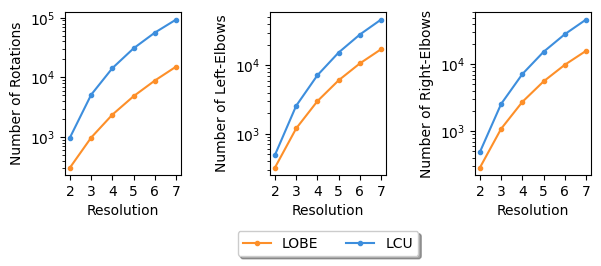

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(16 / 2.54, 6 / 2.54))

numbers_of_terms_LOBE = [DATA_POINT["ASP"]["number_of_terms"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
resolutions = list(range(2, res_max))

left_elbows_asp = [DATA_POINT["ASP"]["left_elbows"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
right_elbows_asp = [DATA_POINT["ASP"]["right_elbows"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
rotations_asp = [DATA_POINT["ASP"]["rotations"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
nonclifford_rotations_asp = [DATA_POINT["ASP"]["number_of_nonclifford_rotations"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# rescaling_factors_asp = [DATA_POINT["ASP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# numbers_of_qubits_asp = [DATA_POINT["ASP"]["number_of_qubits"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# numbers_of_ancillae_asp = [DATA_POINT["ASP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]

# axes[0].plot(numbers_of_terms, rotations_usp, color=BLUE, marker='s', alpha = 1)
# axes[0].plot(numbers_of_terms, rotations_asp, color=ORANGE, marker='.', alpha = 1)
axes[0].plot(resolutions, nonclifford_rotations_asp, color=ORANGE, marker='.', alpha = 1)
axes[0].plot(resolutions, LCU_rots_DATA_FOR_FIXED_OMEGA, color=BLUE, marker='.', alpha = 1)
# axes[0].plot(numbers_of_terms, rotation_upper_bound, color=RED, ls='--', alpha = 1)
axes[0].set_ylabel("Number of Rotations")
# axes[0].set_xlabel("Number of Terms ($L$)")
axes[0].set_xlabel("Resolution")


axes[1].plot(resolutions, left_elbows_asp, color=ORANGE, marker='.', alpha = 1, label = 'LOBE')
axes[1].plot(resolutions, LCU_elbows_DATA_FOR_FIXED_OMEGA, color=BLUE, marker='.', alpha = 1, label = 'LCU')
# axes[1].plot(numbers_of_terms, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[1].set_ylabel("Number of Left-Elbows")
axes[1].set_xlabel("Resolution")

axes[2].plot(resolutions, right_elbows_asp, color=ORANGE, marker='.', alpha = 1)
axes[2].plot(resolutions, LCU_elbows_DATA_FOR_FIXED_OMEGA, color=BLUE, marker='.', alpha = 1)
# axes[2].plot(numbers_of_terms, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[2].set_ylabel("Number of Right-Elbows")
axes[2].set_xlabel("Resolution")

plt.tight_layout()
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[2].set_yscale('log')
axes[0].set_xticks(resolutions)
axes[1].set_xticks(resolutions)
axes[2].set_xticks(resolutions)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=2)
plt.savefig("../manuscript/figures/yukawa_hamiltonian_gates_vs_resolution.pdf", dpi=600)

In [6]:
fix_res = 4

number_of_omega_range = [3, 7, 15, 31]

DATA_FOR_FIXED_RES = []
LCU_rots_DATA_FOR_FIXED_RES = []
LCU_elbows_DATA_FOR_FIXED_RES = []
for Omega in number_of_omega_range:
    start = time()
    print("----{} of {}----".format(Omega, max(number_of_omega_range)))
    DATA_FOR_FIXED_RES.append(generate_yukawa_circuit(fix_res, Omega))
    LCU_rots_DATA_FOR_FIXED_RES.append(2 * op_qubit_map(yukawa_Hamiltonian(fix_res, 1, 1, 1), Omega).n_terms)
    LCU_elbows_DATA_FOR_FIXED_RES.append(op_qubit_map(yukawa_Hamiltonian(fix_res, 1, 1, 1), Omega).n_terms)
    print("* {} (s) *".format(round(time() - start, 1)))

----3 of 31----
* 3.0 (s) *
----7 of 31----
* 6.2 (s) *
----15 of 31----
* 31.6 (s) *
----31 of 31----
* 202.9 (s) *


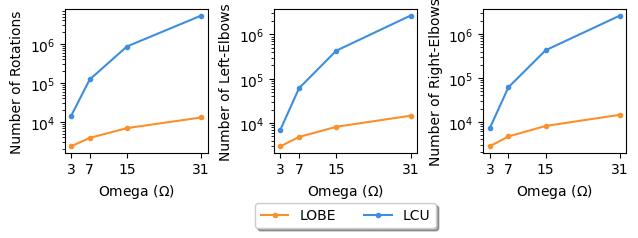

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(16 / 2.54, 6 / 2.54))

omegas = number_of_omega_range

left_elbows_asp = [DATA_POINT["ASP"]["left_elbows"] for DATA_POINT in DATA_FOR_FIXED_RES]
right_elbows_asp = [DATA_POINT["ASP"]["right_elbows"] for DATA_POINT in DATA_FOR_FIXED_RES]
rotations_asp = [DATA_POINT["ASP"]["rotations"] for DATA_POINT in DATA_FOR_FIXED_RES]
nonclifford_rotations_asp = [DATA_POINT["ASP"]["number_of_nonclifford_rotations"] for DATA_POINT in DATA_FOR_FIXED_RES]
# rescaling_factors_asp = [DATA_POINT["ASP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# numbers_of_qubits_asp = [DATA_POINT["ASP"]["number_of_qubits"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]
# numbers_of_ancillae_asp = [DATA_POINT["ASP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_OMEGA]

# axes[0].plot(numbers_of_terms, rotations_usp, color=BLUE, marker='s', alpha = 1)
# axes[0].plot(numbers_of_terms, rotations_asp, color=ORANGE, marker='.', alpha = 1)
axes[0].plot(omegas, nonclifford_rotations_asp, color=ORANGE, marker='.', alpha = 1)
axes[0].plot(omegas, LCU_rots_DATA_FOR_FIXED_RES, color=BLUE, marker='.', alpha = 1)
# axes[0].plot(numbers_of_terms, rotation_upper_bound, color=RED, ls='--', alpha = 1)
axes[0].set_ylabel("Number of Rotations")
# axes[0].set_xlabel("Number of Terms ($L$)")
axes[0].set_xlabel("Omega ($\Omega$)")


axes[1].plot(omegas, left_elbows_asp, color=ORANGE, marker='.', alpha = 1, label = 'LOBE')
axes[1].plot(omegas, LCU_elbows_DATA_FOR_FIXED_RES, color=BLUE, marker='.', alpha = 1, label = 'LCU')
# axes[1].plot(numbers_of_terms, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[1].set_ylabel("Number of Left-Elbows")
axes[1].set_xlabel("Omega ($\Omega$)")

axes[2].plot(omegas, right_elbows_asp, color=ORANGE, marker='.', alpha = 1)
axes[2].plot(omegas, LCU_elbows_DATA_FOR_FIXED_RES, color=BLUE, marker='.', alpha = 1)
# axes[2].plot(numbers_of_terms, elbow_upper_bound, color=RED, ls='--', alpha = 1)
axes[2].set_ylabel("Number of Right-Elbows")
axes[2].set_xlabel("Omega ($\Omega$)")

plt.tight_layout()
axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[2].set_yscale('log')
axes[0].set_xticks(omegas)
axes[1].set_xticks(omegas)
axes[2].set_xticks(omegas)
axes[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
          fancybox=True, shadow=True, ncol=2)
plt.savefig("../manuscript/figures/yukawa_hamiltonian_gates_vs_omega.pdf", dpi=600)

In [8]:
numbers_of_ancillae_asp_fix_omega = [DATA_POINT["ASP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_OMEGA ]
rescaling_factors_asp_fix_omega = [DATA_POINT["ASP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_OMEGA ]

numbers_of_ancillae_LCU_fix_omega = [2 * np.log2(op_qubit_map(yukawa_Hamiltonian(res, 1, 1, 1), fix_Omega).n_terms) for res in number_of_res_range]
rescaling_factors_LCU_fix_omega = [np.linalg.norm((op_qubit_map(yukawa_Hamiltonian(res, 1, 1, 1), fix_Omega).coeff_vec), ord=1) for res in number_of_res_range]

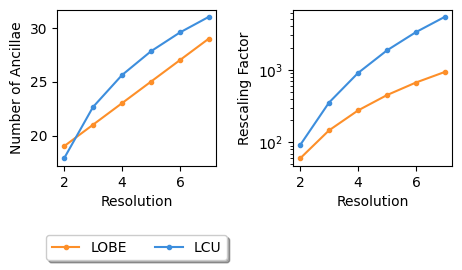

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(12 / 2.54, 8 / 2.54))

axes[0].plot(number_of_res_range, numbers_of_ancillae_asp_fix_omega, color=ORANGE, marker='.', alpha = 1, label = 'LOBE')
axes[0].plot(number_of_res_range, numbers_of_ancillae_LCU_fix_omega, color=BLUE, marker='.', alpha = 1, label = 'LCU')

axes[1].plot(number_of_res_range, rescaling_factors_asp_fix_omega, color=ORANGE, marker='.', alpha = 1, label = 'LOBE')
axes[1].plot(number_of_res_range, rescaling_factors_LCU_fix_omega, color=BLUE, marker='.', alpha = 1, label = 'LCU')


axes[0].set_ylabel('Number of Ancillae')
axes[0].set_xlabel('Resolution')
axes[1].set_ylabel('Rescaling Factor')
axes[1].set_xlabel('Resolution')
axes[1].set_yscale('log')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("../manuscript/figures/yukawa_ancillae_vs_resolution.pdf", dpi=600)

In [10]:
numbers_of_ancillae_asp_fix_res = [DATA_POINT["ASP"]["number_of_ancillae"] for DATA_POINT in DATA_FOR_FIXED_RES ]
rescaling_factors_asp_fix_res = [DATA_POINT["ASP"]["rescaling_factor"] for DATA_POINT in DATA_FOR_FIXED_RES ]

numbers_of_ancillae_LCU_fix_res = [np.log2(op_qubit_map(yukawa_Hamiltonian(fix_res, 1, 1, 1), Omega).n_terms) for Omega in number_of_omega_range]
rescaling_factors_LCU_fix_res = [np.linalg.norm((op_qubit_map(yukawa_Hamiltonian(fix_res, 1, 1, 1), Omega).coeff_vec), ord=1) for Omega in number_of_omega_range]

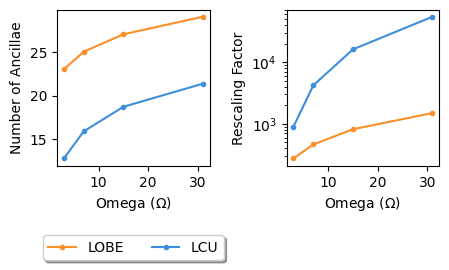

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12 / 2.54, 8 / 2.54))

axes[0].plot(number_of_omega_range, numbers_of_ancillae_asp_fix_res, color=ORANGE, marker='.', alpha = 1, label = 'LOBE')
axes[0].plot(number_of_omega_range, numbers_of_ancillae_LCU_fix_res, color=BLUE, marker='.', alpha = 1, label = 'LCU')

axes[1].plot(number_of_omega_range, rescaling_factors_asp_fix_res, color=ORANGE, marker='.', alpha = 1, label = 'LOBE')
axes[1].plot(number_of_omega_range, rescaling_factors_LCU_fix_res, color=BLUE, marker='.', alpha = 1, label = 'LCU')


axes[0].set_ylabel('Number of Ancillae')
axes[0].set_xlabel('Omega ($\Omega$)')
axes[1].set_ylabel('Rescaling Factor')
axes[1].set_xlabel('Omega ($\Omega$)')
axes[1].set_yscale('log')
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.4),
          fancybox=True, shadow=True, ncol=2)
plt.tight_layout()
plt.savefig("../manuscript/figures/yukawa_ancillae_vs_omega.pdf", dpi=600)